### site frequency spectrum plot

In [1]:
%run setup.ipynb
callset_pass = phase2_ar1.callset_pass_biallelic
accessibility = phase2_ar1.accessibility
df_samples = phase2_ar1.df_samples
df_samples = df_samples.reset_index()
populations = phase2_ar1.pop_ids
pop_colours = phase2_ar1.pop_colors
pop_labels = phase2_ar1.pop_labels
region_3L_free = '3L-free', '3L', 15000000, 41000000
region_3R_free = '3R-free', '3R', 1, 37000000
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def load_tbl_samples_sub(chrom, subsets, seed):
    
    random.seed(seed)
    
    with section('compute subset sizes'):
        subset_sizes = [len(df_samples[df_samples.population == q]) for q in populations]
        n = min(subset_sizes)

    subsets_sidx = dict()
    for p in populations:
        subsets_sidx[p] = sorted(list(df_samples[df_samples.population == p].index))

    sidx = list(itertools.chain(*subsets_sidx.values()))
    
    return sidx, subsets_sidx 

In [3]:
sidx, subsets_sidx = load_tbl_samples_sub('3R', populations, 42)

[compute subset sizes] begin
[compute subset sizes] done in a moment


In [4]:
@functools.lru_cache(maxsize=None)
def compute_sfs(chrom, start, stop, pop):
    pos = allel.SortedIndex(callset_pass[chrom]['variants/POS'])
    locr = pos.locate_range(start, stop)
    genotype = allel.GenotypeDaskArray(callset_pass[chrom]['calldata/genotype'])
    genotype_sub = genotype.take(subsets_sidx[pop], axis=1)
    ac_sub = genotype_sub.count_alleles(max_allele=3).compute()
    ac = ac_sub[locr]
    loca = (ac.max_allele() <= 1) & (ac.is_segregating())
    aca = ac[loca][:, :2]
    n = np.max(ac.sum(axis=1))
    s = allel.sfs_folded_scaled(aca)
    return s, n

def compute_3_free_accessible_length():
    _, chrom, start, stop = region_3L_free
    is_accessible = accessibility[chrom]['is_accessible'][start-1:stop]
    l = np.count_nonzero(is_accessible)
    _, chrom, start, stop = region_3R_free
    is_accessible = accessibility[chrom]['is_accessible'][start-1:stop]
    l += np.count_nonzero(is_accessible)
    return l

In [5]:
def plot_sfs_combined(legend=False, ax=None, lw=2, fn=None):
    l = compute_3_free_accessible_length()
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,3))
    # set order for Z
    for pop in populations:
        s1, n1 = compute_sfs(*region_3R_free[1:], pop=pop)
        s2, n2 = compute_sfs(*region_3L_free[1:], pop=pop)
        assert n1 == n2
        s = s1 + s2
        s = s / l
        allel.plot_sfs_folded_scaled(s, n=n1, label=pop, ax=ax, 
                                           plot_kwargs=dict(color=pop_colours[pop],
                                                            lw=lw, alpha=0.8))
    ax.set_ylabel('variant density (bp$^{-1}$)')
    ax.set_ylim(0, 0.1)
    ax.set_xlim(0, 0.5)
#     if legend:
#         ax.legend()


    handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop_labels[pop]) for pop in populations]
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(-0.07, 1.1), ncol=3, labelspacing=0.8)
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=300, bbox_inches='tight');

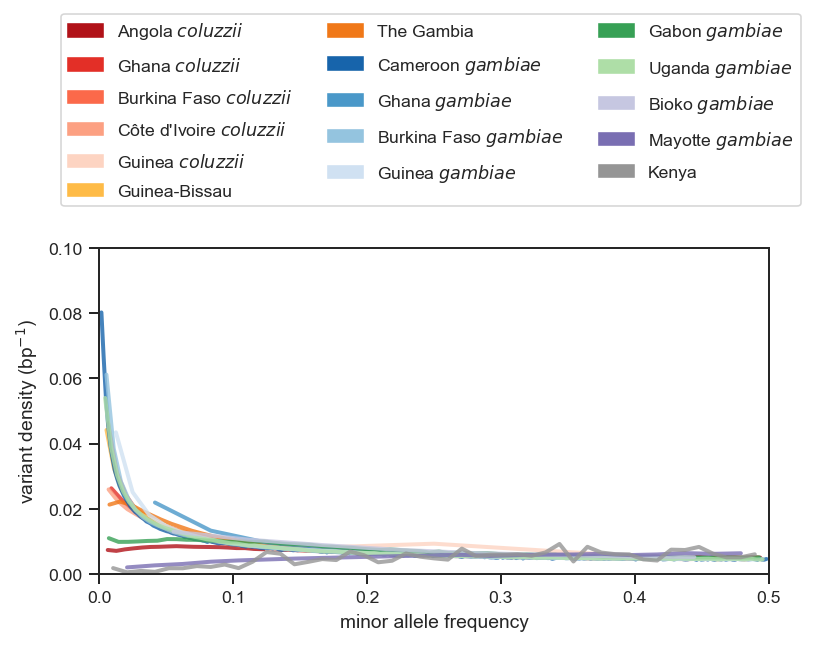

In [6]:
plot_sfs_combined(legend=True, fn='../artwork/sfs_all.jpeg')

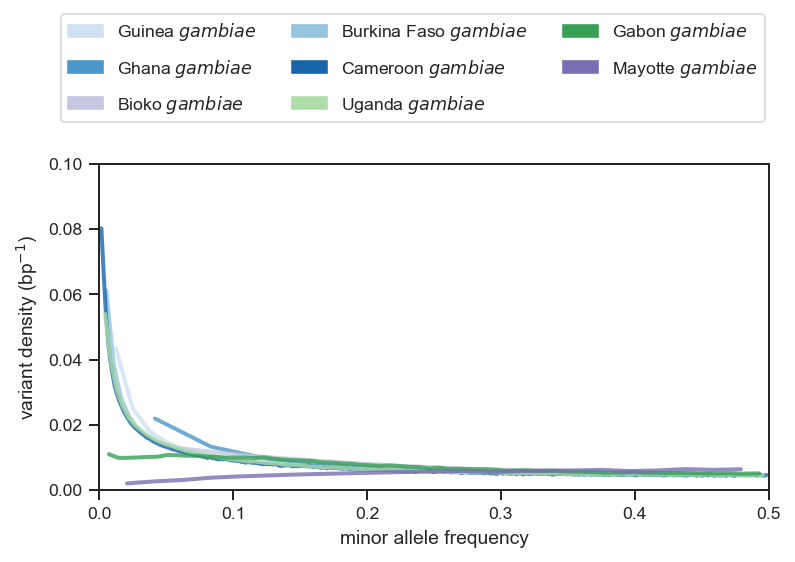

In [7]:
populations = ['GNgam', 'GHgam', 'GQgam', 'BFgam', 'CMgam', 'UGgam', 'GAgam', 'FRgam']
plot_sfs_combined(legend=True, fn='../artwork/sfs_gam.jpeg')

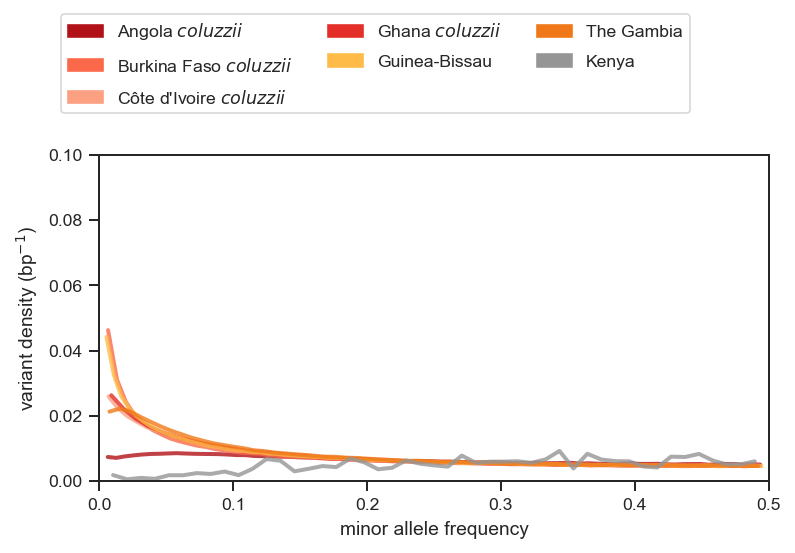

In [8]:
populations = ['AOcol', 'BFcol', 'CIcol', 'GHcol', 'GW', 'GM', 'KE']
plot_sfs_combined(legend=True, fn='../artwork/sfs_col.jpeg')